In [ ]:
# 파이토치

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import argparse
import time
from copy import deepcopy
import matplotlib.pyplot as plt

In [7]:
class View(nn.Module):
    
    def __init__(self, *shape): # 몇 개의 shape이 들어오든 상관이 없다, *이 하나면 tuple, 두개면 딕셔너리 형태로 저장
        super(View, self).__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(x.shape[0], *self.shape) # x.shape = [batch_size, channel, width, height]
    
    # x.view가 resize - 차원을 바꿔준다. 파이토치의 데이터가 기본적으로 [batch_size, channel, width, height] 이런 형태를 띠고 있다.
    # View(-1) = x.shape[0], *self.shape:  batch_size, 그리고 나머지라는 뜻

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__() # super: nn.Module 클래스를 상속받는다
        
        layers = []
        
        layers += [nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
                  nn.ReLU(inplace=True), # relu를 통과한 값이 갱신되도록 해주는게 inplace=True
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                  nn.ReLU(inplace=True),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  View(-1), # 우리가 봤을 땐 1차원인 데이터를 컴퓨터는 4차원으로 보기 때문에 그걸 해결하기 위함
                  nn.Linear(in_features=3136, out_features=128), # out_feature는 내 맘, 3136 = 64*7*7
                  nn.ReLU(inplace=True),
                  nn.Linear(in_features=128, out_features=10),
                  nn.ReLU(inplace=True)]
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw


Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw


Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw


Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw
Processing...
Done!
Device :  cpu
Epoch 0, acc(train/val) 38.21114/43.34936. Took 173.11 sec
Epoch 1, acc(train/val) 49.47750/55.60897. Took 173.78 sec
Epoch 2, acc(train/val) 58.30329/64.38301. Took 173.65 sec
Epoch 3, acc(train/val) 68.86518/71.79487. Took 172.87 sec
Epoch 4, acc(train/val) 70.91847/70.32252. Took 176.82 sec


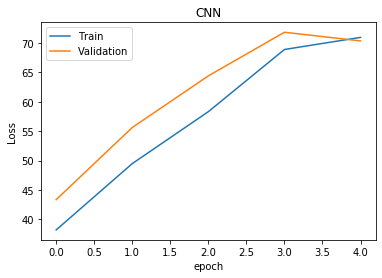

In [8]:
# MNIST 데이터에 대해서 훈련 및 검증

# initial parameters

seed = 6 # weight 초깃값 설정: 이렇게 설정해주면 돌릴때마다 weight 안변함
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 256
args.model = CNN()
args.loss_fn = nn.CrossEntropyLoss()
args.lr = 0.01
args.epoch = 5

#데이터 준비

train_datasets = MNIST(root='./datasets', train=True, transform=ToTensor(), download=True)
validation_datasets = MNIST(root='./datasets', train=False, transform=ToTensor(), download=True)

# .item = 그 값을 가져온다
# eq = pred 된 값 중 가장 확률 큰 값이랑 true 값이랑 얼마나 같으냐

def acc(y_pred, y_true, batch_size):
    accuracy = torch.sum(torch.eq(torch.argmax(y_pred, dim=1), y_true)).item() / batch_size * 100 
    return accuracy

def train(model, datasets, optimizer, loss_fn, args):
    trainloader = DataLoader(dataset=datasets,
                             batch_size=args.batch_size,
                             shuffle=True,
                             drop_last=True) # drop_last: 데이터는 6만개인데 배치사이즈가 256이면 딱 안나눠지니까 나머지는 떨구는 것
    model.train() # 이번 모델은 train에 쓰겠다
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0

    for i, (X, y) in enumerate (trainloader): # 데이터를 만들어주는 것
        X = X.to(args.device)
        y_true = y.to(args.device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y_true)
        accuracy = acc(y_pred=y_pred, y_true= y_true, batch_size=args.batch_size)

        model.zero_grad() # 초기화하라
        optimizer.zero_grad() # 초기화하라
        loss.backward() # 로스 (오류) 역전파해라
        optimizer.step() # 옵티마이저는 가중치를 갱신하라

        train_acc += accuracy

    train_acc = train_acc / len(trainloader)

    return train_acc

def validate(model, datasets, args):
    valloader = DataLoader(dataset=datasets,
                             batch_size=args.batch_size,
                             shuffle=False,
                             drop_last=True)
    model.eval() # 이번 모델은 val에 쓰겠다

    val_acc = 0.0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y_true = y.to(args.device)
            y_pred = model(X)

            accuracy = acc(y_pred=y_pred, y_true=y_true, batch_size=args.batch_size)
            val_acc += accuracy

    val_acc = val_acc / len(valloader)

    return val_acc

def training(train_datasets, val_datasets, args):
    model = args.model
    model.to(args.device)

    print('Device : ', args.device)

    loss_fn = args.loss_fn
    optimizer = optim.SGD(model.parameters(), lr=args.lr) # 모델의 parameter들과 learnig rate를 참고해라

    epoch_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(args.epoch):
        ts = time.time()

        train_acc = train(model=model, datasets=train_datasets, optimizer=optimizer, loss_fn=loss_fn, args=args)
        val_acc = validate(model=model, datasets=val_datasets, args=args)

        te = time.time()

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        epoch_list.append(epoch)
        print('Epoch {}, acc(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch,train_acc,val_acc,te - ts))                                                                                                                                                             
                                                                                 
    plt.title('CNN')
    plt.plot(epoch_list, train_acc_list)
    plt.plot(epoch_list, val_acc_list)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.show()

    torch.save(model.state_dict(), 'CNN.pt') # 모델의 가중치 상태를 dict형태로 저장

# 모델 훈련시키기
    
training(train_datasets, validation_datasets, deepcopy(args))

# model = CNN()
# model.load_stat_dict(torch.load('CNN.pt'))를 쓰면 원래 사용하던 모델을 불러와서 이어서 쓸 수 있다

In [ ]:
# 케라스

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.models import Model

In [ ]:
# Conv 레이어 계산 실험

model = models.Sequential()
model.add(Conv2D(input_shape = (112,112,1), filters = 64, kernel_size = (7,7), strides = 2, padding = 'same'))
print(model.output_shape)

In [19]:
# Sequential 없이도 모델 만드는 방법

inputs = Input(shape=(28,28,1))
conv = Conv2D(filters=32, kernel_size = (3,3), strides=(1,1), padding='same')(inputs)
activation = Activation('relu')(conv) # same이 제로패딩, stride 기본값이 (1,1)
maxpooling = MaxPooling2D(pool_size=(2,2))(activation)
dropout = Dropout(0.5)(maxpooling)
conv = Conv2D(filters=64, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu')(maxpooling)
maxpooling = MaxPooling2D(pool_size=(2,2))(conv)
dropout = Dropout(0.5)(maxpooling)
flatten = Flatten()(dropout)
dense = Dense(128, activation = 'relu')(flatten)
outputs = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=inputs, outputs=outputs)

model.summary() # inputs = Input(shape=(28,28,1), name = '~~') 하면 summary했을때 내가 지정한 name으로 설정됨

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 7, 64)          0   

KeyboardInterrupt: 

In [10]:
# mnist 데이터 준비

import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils

width = 28
height = 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, width, height, 1).astype('float32')/255.0
x_test = x_test.reshape(10000, width, height, 1).astype('float32')/255.0

num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
# 모델 훈련

# 한 에폭에 100번 돌고 (훈련데이터 54000개 = 배치사이즈 540*100) 그걸 전체 10번 반복
# validation_split: 훈련셋에서 10프로만 val로 만든다, 

# model.fit_generator와는 조금 다르다: 거기엔 steps_per_epoch가 들어가고 그 변수 자체에 batch size의 표현이 내재되어 있다.

model.fit(x_train, y_train, batch_size=540, epochs=10, verbose = 2, validation_split=0.1) 
score = model.evaluate(x_test, y_test) # [loss, acc]

print('loss: ', score[0])
print('acc: ', score[1])

In [ ]:
# model 저장

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# weight 저장

model.save_weights("model.h5")

# model 불러오기

from keras.models import model_from_json
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

loaded_model.compile()
loaded_model.evalute()